# Original CSV - Solve 2x2 Puzzle with 70/15/15 Split

In [ ]:
import cv2
import numpy as np
import pandas as pd
import random
import glob
import csv
import keras
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Create function for tiles images

In [ ]:
def tiles_images(img, pieces):
    img_width = img_height = img.shape[1] // pieces
    tiles_img = [img[x:x+img_height,y:y+img_width]
                 for x in range(0,img.shape[0], img_height)
                 for y in range(0,img.shape[1],img_width)
                ]

    new_tiles = []

    for img in tiles_img:
        if img.shape[0] == img_width and  img.shape[1] == img_height:
            new_tiles.append(img)

    return new_tiles

Create function for group images

In [ ]:
def group_image(images, shuffle_arr, pieces=4):
    img = []

    print(shuffle_arr)

    new_order = [images[i] for i in shuffle_arr]

    for i in range(pieces):
        img.append(np.concatenate(new_order[i * pieces:(i + 1) * pieces], axis=1))

    img = np.concatenate(img, axis=0)
    return img

In [ ]:
def load_data(base_path, path, pieces=2):
    data = pd.read_csv(base_path + '{}.csv'.format(path))
    path = base_path + path + '/'

    x, y = [], []
    for i in range(len(data)):
        im = Image.open(path + str(i) + '.jpg')
        im = np.array(im).astype('float16')
        im = im / 255 - 0.5

        if path.split('/')[-2] == 'test':
            x.append(im)
        else:
            x.append(tiles_images(im, pieces))

        label = data.iloc[i]
        label = [int(i) for i in label]
        y.append(label)

    return (np.array(x), np.expand_dims(np.array(y), axis=-1))

Define base path

In [ ]:
base_path = "/content/drive/My Drive/668Project/puzzle_7030/"

Download data for train, test and validation

In [ ]:
x_train, y_train = load_data(base_path, 'train')

In [ ]:
x_val, y_val = load_data(base_path, 'valid')

In [ ]:
x_test, y_test = load_data(base_path, 'test')

Train model for puzzle 2x2

In [ ]:
import keras
from keras.layers import TimeDistributed as td
from keras.layers import Conv2D, Flatten, Dense, ZeroPadding2D, Activation
from keras.layers import MaxPooling2D, Dropout, BatchNormalization, Reshape

In [ ]:
def get_model():

    model = keras.models.Sequential()

    model.add(td(ZeroPadding2D(2), input_shape=(4, 112, 112, 3)))

    model.add(td(Conv2D(50, kernel_size=(5,5), padding='same', activation='relu', strides=2)))
    model.add(td(BatchNormalization()))
    model.add(td(MaxPooling2D()))

    model.add(td(Conv2D(100, kernel_size=(5,5), padding='same', activation='relu', strides=2)))
    model.add(td(BatchNormalization()))
    model.add(td(Dropout(0.3)))

    model.add(td(Conv2D(100, kernel_size=(3,3), padding='same', activation='relu', strides=2)))
    model.add(td(BatchNormalization()))
    model.add(td(Dropout(0.3)))

    model.add(td(Conv2D(200, kernel_size=(3,3), padding='same', activation='relu', strides=1)))
    model.add(td(BatchNormalization()))
    model.add(td(Dropout(0.3)))

    model.add(Flatten())

    model.add(Dense(600, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(400, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(16))
    model.add(Reshape((4, 4)))
    model.add(Activation('softmax'))

    return model

In [ ]:
model = get_model()

In [ ]:
adam = keras.optimizers.Adam(learning_rate=.001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])

In [ ]:
x_train.shape

(509, 4, 112, 112, 3)

In [ ]:
y_train.shape

(509, 4, 1)

In [ ]:
model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val, y_val))

Epoch 1/100
8/8 [==============================] - 17s 286ms/step - loss: 2.0875 - sparse_categorical_accuracy: 0.3021 - val_loss: 1.3679 - val_sparse_categorical_accuracy: 0.2932
Epoch 2/100
8/8 [==============================] - 1s 104ms/step - loss: 1.1183 - sparse_categorical_accuracy: 0.5599 - val_loss: 1.3849 - val_sparse_categorical_accuracy: 0.2841
Epoch 3/100
8/8 [==============================] - 1s 111ms/step - loss: 0.7014 - sparse_categorical_accuracy: 0.7254 - val_loss: 1.3689 - val_sparse_categorical_accuracy: 0.3068
Epoch 4/100
8/8 [==============================] - 1s 121ms/step - loss: 0.4279 - sparse_categorical_accuracy: 0.8497 - val_loss: 1.3463 - val_sparse_categorical_accuracy: 0.3614
Epoch 5/100
8/8 [==============================] - 1s 125ms/step - loss: 0.2578 - sparse_categorical_accuracy: 0.9180 - val_loss: 1.3738 - val_sparse_categorical_accuracy: 0.3386
Epoch 6/100
8/8 [==============================] - 1s 127ms/step - loss: 0.1744 - sparse_categorical_acc

Check

1/1 [==============================] - 0s 348ms/step
[2 0 3 1]
1/1 [==============================] - 0s 18ms/step
[0 2 2 3]
1/1 [==============================] - 0s 19ms/step
[3 1 1 0]
1/1 [==============================] - 0s 17ms/step
[1 0 2 2]
1/1 [==============================] - 0s 20ms/step
[2 0 2 1]
1/1 [==============================] - 0s 21ms/step
[1 3 2 0]
1/1 [==============================] - 0s 17ms/step
[1 1 0 2]
1/1 [==============================] - 0s 19ms/step
[3 1 1 0]
1/1 [==============================] - 0s 19ms/step
[0 1 3 2]
1/1 [==============================] - 0s 18ms/step
[0 2 3 1]


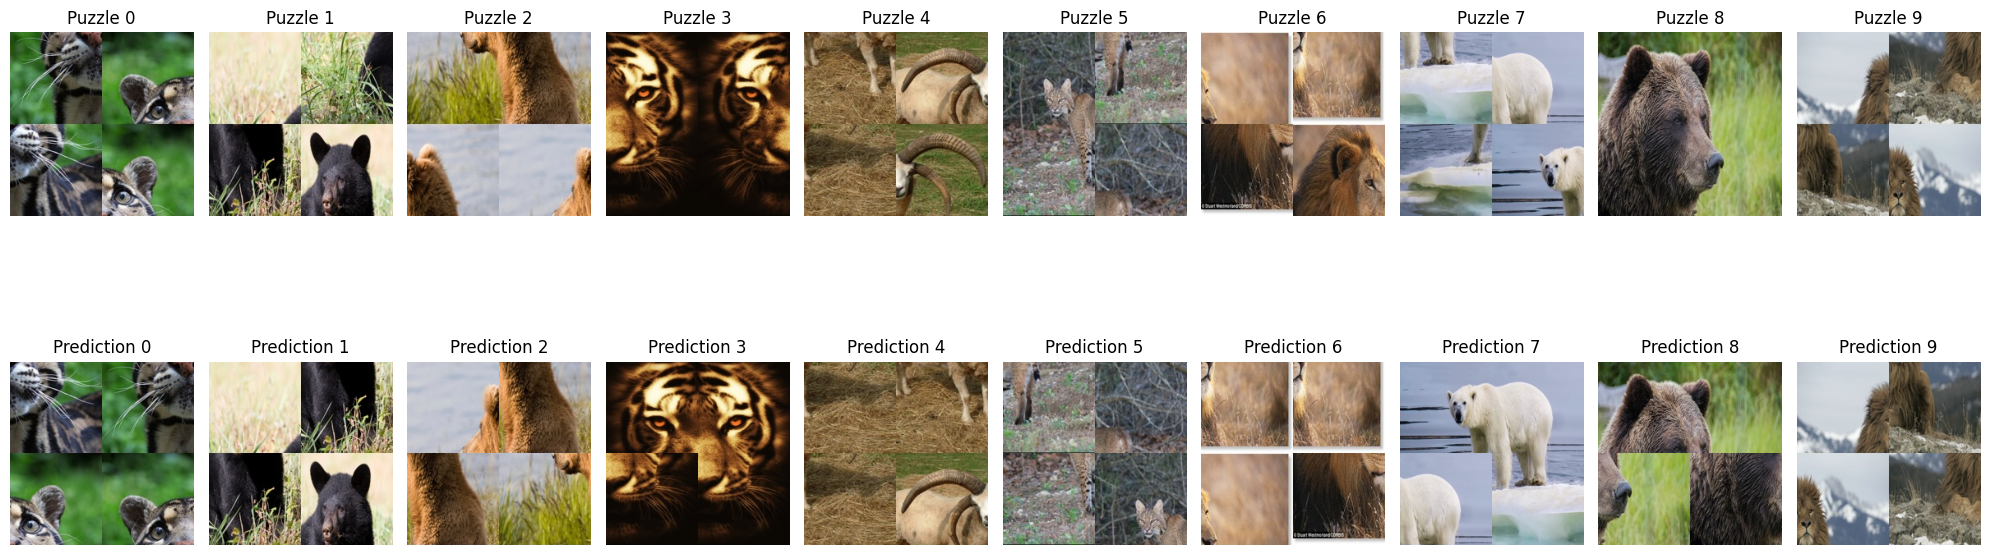

In [ ]:
fig, axes = plt.subplots(2, 10, figsize=(20, 8))  # 2 rows, 10 columns

for i in range(10):
    image = x_test[i].astype('float64') + 0.5
    axes[0, i].imshow(image)
    axes[0, i].set_title(f"Puzzle {i}")
    axes[0, i].axis('off')

    inp = np.expand_dims(tiles_images(x_test[i], pieces=2), axis=0)
    y_pred = model.predict(inp)[0]
    y_pred = np.argmax(y_pred, axis=1)

    tiles = tiles_images(image, pieces=2)
    predit_img = group_image(tiles, y_pred, pieces=2)

    axes[1, i].imshow(predit_img)
    axes[1, i].set_title(f"Prediction {i}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Correctly solved: 0/10

# New CSV - Solve 2x2 Puzzle with 70/15/15 Split

Create function for tiles images

In [ ]:
def tiles_images(img, pieces):
    img_width = img_height = img.shape[1] // pieces
    tiles_img = [img[x:x+img_height,y:y+img_width]
                 for x in range(0,img.shape[0], img_height)
                 for y in range(0,img.shape[1],img_width)
                ]

    new_tiles = []

    for img in tiles_img:
        if img.shape[0] == img_width and  img.shape[1] == img_height:
            new_tiles.append(img)

    return new_tiles

Create function for group images

In [ ]:
def group_image(images, shuffle_arr, pieces=4):
    img = []

    print(shuffle_arr)

    new_order = [images[i] for i in shuffle_arr]

    for i in range(pieces):
        img.append(np.concatenate(new_order[i * pieces:(i + 1) * pieces], axis=1))

    img = np.concatenate(img, axis=0)
    return img

In [ ]:
def load_data(base_path, path, pieces=2):
    data = pd.read_csv(base_path + '{}1.csv'.format(path))
    path = base_path + path + '/'

    x, y = [], []
    for i in range(len(data)):
        im = Image.open(path + str(i) + '.jpg')
        im = np.array(im).astype('float16')
        im = im / 255 - 0.5

        if path.split('/')[-2] == 'test':
            x.append(im)
        else:
            x.append(tiles_images(im, pieces))

        label = data.iloc[i]
        label = [int(i) for i in label]
        y.append(label)

    return (np.array(x), np.expand_dims(np.array(y), axis=-1))

Define base path

In [ ]:
base_path = "/content/drive/My Drive/668Project/puzzle_7030/"

Download data for train, test and validation

In [ ]:
x_train, y_train = load_data(base_path, 'train')

In [ ]:
x_val, y_val = load_data(base_path, 'valid')

In [ ]:
x_test, y_test = load_data(base_path, 'test')

Train model for puzzle 2x2

In [ ]:
import keras
from keras.layers import TimeDistributed as td
from keras.layers import Conv2D, Flatten, Dense, ZeroPadding2D, Activation
from keras.layers import MaxPooling2D, Dropout, BatchNormalization, Reshape

In [ ]:
def get_model():

    model = keras.models.Sequential()

    model.add(td(ZeroPadding2D(2), input_shape=(4, 112, 112, 3)))

    model.add(td(Conv2D(50, kernel_size=(5,5), padding='same', activation='relu', strides=2)))
    model.add(td(BatchNormalization()))
    model.add(td(MaxPooling2D()))

    model.add(td(Conv2D(100, kernel_size=(5,5), padding='same', activation='relu', strides=2)))
    model.add(td(BatchNormalization()))
    model.add(td(Dropout(0.3)))

    model.add(td(Conv2D(100, kernel_size=(3,3), padding='same', activation='relu', strides=2)))
    model.add(td(BatchNormalization()))
    model.add(td(Dropout(0.3)))

    model.add(td(Conv2D(200, kernel_size=(3,3), padding='same', activation='relu', strides=1)))
    model.add(td(BatchNormalization()))
    model.add(td(Dropout(0.3)))

    model.add(Flatten())

    model.add(Dense(600, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(400, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(16))
    model.add(Reshape((4, 4)))
    model.add(Activation('softmax'))

    return model

In [ ]:
model = get_model()

In [ ]:
adam = keras.optimizers.Adam(learning_rate=.001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])

In [ ]:
x_train.shape

(509, 4, 112, 112, 3)

In [ ]:
y_train.shape

(509, 4, 1)

In [ ]:
model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val, y_val))

Epoch 1/100
8/8 [==============================] - 6s 232ms/step - loss: 2.1364 - sparse_categorical_accuracy: 0.2741 - val_loss: 1.3761 - val_sparse_categorical_accuracy: 0.2750
Epoch 2/100
8/8 [==============================] - 1s 117ms/step - loss: 1.1881 - sparse_categorical_accuracy: 0.5260 - val_loss: 1.3840 - val_sparse_categorical_accuracy: 0.2773
Epoch 3/100
8/8 [==============================] - 1s 107ms/step - loss: 0.8174 - sparse_categorical_accuracy: 0.6861 - val_loss: 1.4486 - val_sparse_categorical_accuracy: 0.3159
Epoch 4/100
8/8 [==============================] - 1s 107ms/step - loss: 0.5291 - sparse_categorical_accuracy: 0.8134 - val_loss: 1.4447 - val_sparse_categorical_accuracy: 0.2955
Epoch 5/100
8/8 [==============================] - 1s 115ms/step - loss: 0.3468 - sparse_categorical_accuracy: 0.8856 - val_loss: 1.4305 - val_sparse_categorical_accuracy: 0.3000
Epoch 6/100
8/8 [==============================] - 1s 115ms/step - loss: 0.2050 - sparse_categorical_accu

Check

1/1 [==============================] - 0s 214ms/step
[1 3 0 2]
1/1 [==============================] - 0s 18ms/step
[0 3 1 3]
1/1 [==============================] - 0s 18ms/step
[3 2 3 0]
1/1 [==============================] - 0s 20ms/step
[1 2 2 1]
1/1 [==============================] - 0s 20ms/step
[1 1 0 3]
1/1 [==============================] - 0s 18ms/step
[0 0 2 1]
1/1 [==============================] - 0s 17ms/step
[2 1 3 3]
1/1 [==============================] - 0s 17ms/step
[3 2 1 0]
1/1 [==============================] - 0s 23ms/step
[0 1 2 3]
1/1 [==============================] - 0s 17ms/step
[0 3 1 2]


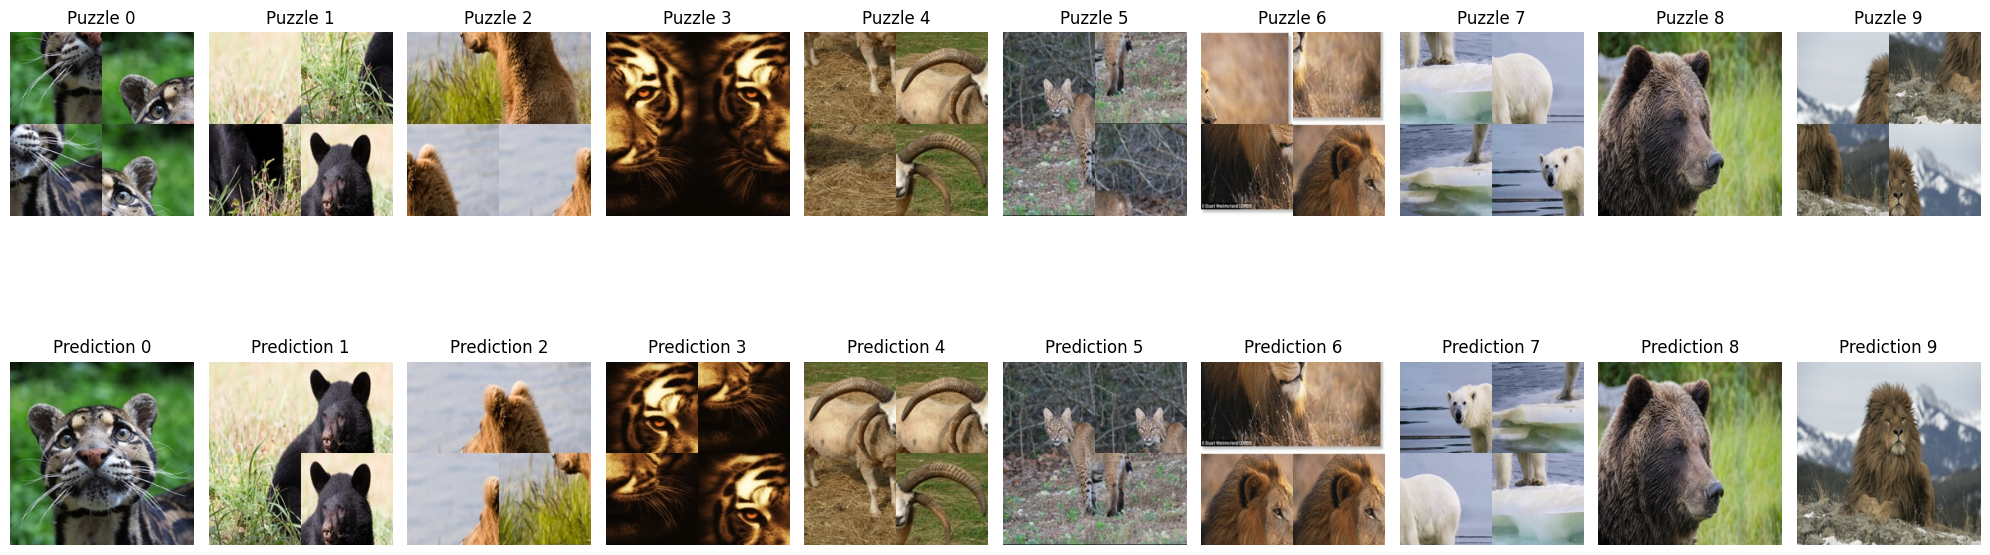

In [ ]:
fig, axes = plt.subplots(2, 10, figsize=(20, 8))  # 2 rows, 10 columns

for i in range(10):
    image = x_test[i].astype('float64') + 0.5
    axes[0, i].imshow(image)
    axes[0, i].set_title(f"Puzzle {i}")
    axes[0, i].axis('off')

    inp = np.expand_dims(tiles_images(x_test[i], pieces=2), axis=0)
    y_pred = model.predict(inp)[0]
    y_pred = np.argmax(y_pred, axis=1)

    tiles = tiles_images(image, pieces=2)
    predit_img = group_image(tiles, y_pred, pieces=2)

    axes[1, i].imshow(predit_img)
    axes[1, i].set_title(f"Prediction {i}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Correctly solved: 3/10